
---
HK-PPI-hubs
---
Martin Loza
--
2023/12/04
--




On this notebook I would like to compare the cell types distribution of weighted counts by chromosomes. I would like to see if there is any strong differences between cell types.
In a previous notebook I tested the mcool files and the cooler package to import the bin information.


In [142]:
import cooler
import matplotlib.pyplot as plt
import pandas as pd
import h5py

#Global variables
date = 231211
seed = 777
in_dir = "/Volumes/MARTIN_LOZA/Projects/HK_Interactions/Data/HiC/SRA/mcool/"
our_dir = "~/Documents/Projects/HK_Interactions/Analysis/2023_12_12/Results/"

In [143]:
#test for importing cooler
#cooler.fileops.list_coolers(in_dir + "GM12878-HindIII-allReps-filtered.mcool" )
res = 10000
tcooler = cooler.Cooler(in_dir + "GM12878-HindIII-allReps-filtered.mcool::resolutions/" + str(res))
# tcooler = cooler.Cooler(in_dir + "K562-HindIII-allReps-filtered.mcool::resolutions/" + str(res))

I have been reading the documentation in internet of cooler [https://buildmedia.readthedocs.org/media/pdf/cooler/latest/cooler.pdf]. Though, I still don't understand everything perfectly. This is what I know now. 

Cool files includes the bin, and pixel information. After normalizing with ICE, a weight column is stored in the bin data. Using this weight we can normalize the counts in bins by multiplying the bin by the appropiate weights. For example bin1 = 0, bin2 = 1, counts = X, then the normalize will be norm=counts * weight(bin0) * weight(bin1).

This can be done with the cool package by loading the bins with the parameter "balance" to true. Also we can load the bins as bedpe files with the parameter join = true. 

In [144]:
#exploring the bins
tcooler.bins()[:10]
#they have weight normalization column

,chrom,start,end,weight
0,chr1,0,10000,NaN
1,chr1,10000,20000,NaN
2,chr1,20000,30000,NaN
3,chr1,30000,40000,NaN
4,chr1,40000,50000,NaN
5,chr1,50000,60000,NaN
6,chr1,60000,70000,NaN
7,chr1,70000,80000,NaN
8,chr1,80000,90000,NaN
9,chr1,90000,100000,NaN


In [145]:
#exploring the pixels
tcooler.pixels()[:10]
#they are not normalized, so we need to normalize them using the weight column

,bin1_id,bin2_id,count
0,1,68947,2
1,1,72744,2
2,1,82099,2
3,1,239986,2
4,1,267234,2
5,1,285520,2
6,1,303111,2
7,2,36254,2
8,2,153687,2
9,3,57166,2


In [146]:
#exploring the matrix balance. This uses the weight column to normalize the pixels. 
#We could use this matrix to get a average matrix for all the cell types.
tcooler.matrix(balance=True, as_pixels=True, join=True)[1:3,5:10]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced


Let's analyse the matrix information in one cell type. In this test, I would like to ignore the inter-chromosome interactions.

In [147]:
#lets get the matrix for a specific cell type
matrix = tcooler.matrix(balance=True, as_pixels=True, join=True)[:]
matrix = pd.DataFrame(matrix)

In [148]:
#inter-chromosomal interactions
matrix[matrix["chrom1"] != matrix["chrom2"]]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced
0,chr1,10000,20000,chr4,10000,20000,2,NaN
1,chr1,10000,20000,chr4,37980000,37990000,2,NaN
2,chr1,10000,20000,chr4,131530000,131540000,2,NaN
3,chr1,10000,20000,chr15,101350000,101360000,2,NaN
4,chr1,10000,20000,chr19,17850000,17860000,2,NaN
...,...,...,...,...,...,...,...,...
72690150,chr22,50790000,50800000,chrX,71360000,71370000,2,0.003031
72690151,chr22,50790000,50800000,chrX,145470000,145480000,2,0.004890
72690152,chr22,50790000,50800000,chrX,148070000,148080000,2,0.005239
72690153,chr22,50790000,50800000,chrX,154540000,154550000,2,0.003555


We can observe many inter-chromosome interactions. For how, let's remove them

In [149]:
#remove inter chromosomal interactions
matrix = matrix[matrix["chrom1"] == matrix["chrom2"]]
#show inter-choromosomal interaction
matrix[matrix["chrom1"] != matrix["chrom2"]]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced


No more inter-chromosomal interactions. Let's continue

In [150]:
chromosome_1["balanced"]

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
              ...   
10930855    0.089317
10930856    0.047680
10934278    0.255587
10934279    0.192645
10940213    0.512037
Name: balanced, Length: 1420210, dtype: float64

In [151]:
# matrix.to_csv('matrix.tsv', sep='\t', index=False)


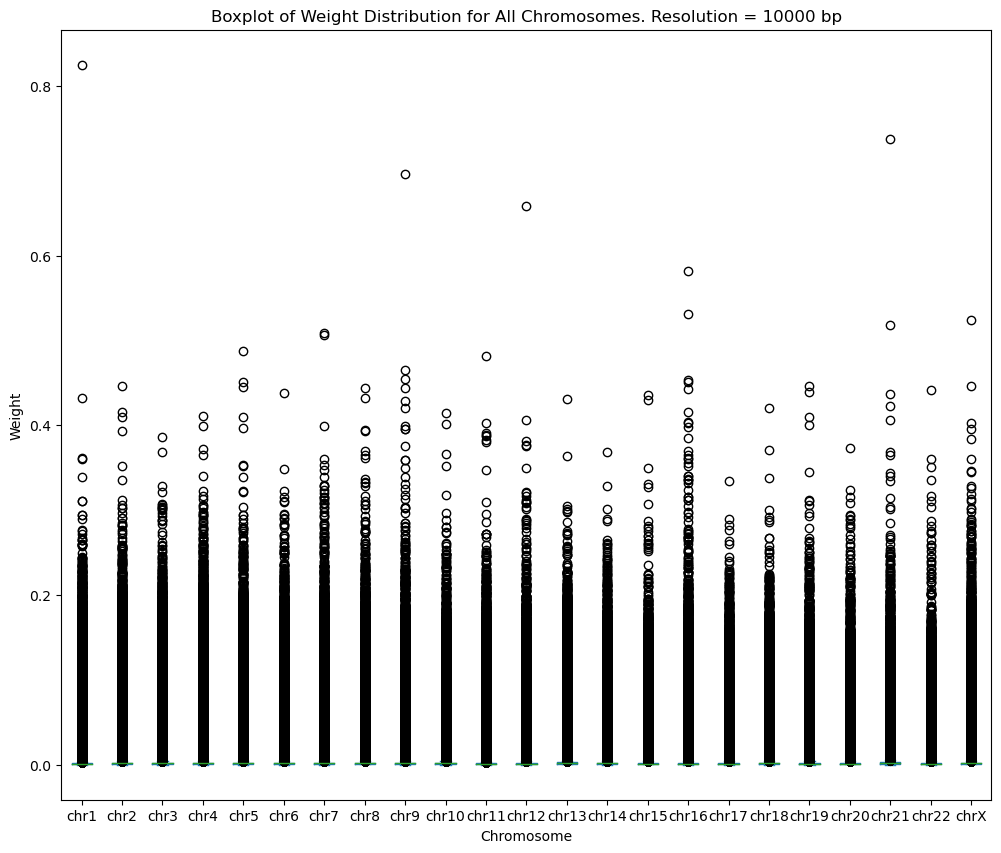

In [152]:
# Get the unique chromosomes in the matrix dataframe
chromosomes = matrix["chrom1"].unique()

# Create an empty list to store the balanced values for each chromosome
balanced_list = []

# Iterate over each chromosome
for chromosome in chromosomes:
    # Get the balanced values for the current chromosome
    balanced_values = matrix[matrix["chrom1"] == chromosome]["balanced"]
    
    # Append the balanced values to the list
    balanced_list.append(balanced_values)

# Convert the list to a data frame
balanced_df = pd.DataFrame(balanced_list, index=chromosomes).T

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 10))

# Create the boxplot
balanced_df.plot.box(ax=ax)
plt.title("Boxplot of Weight Distribution for All Chromosomes. Resolution = " + str(res) + " bp")
plt.xlabel("Chromosome")
plt.ylabel("Weight")
plt.show()


In [ ]:
# Define the list of mcool files for the 5 cell types
mcool_files = [
    in_dir + "GM12878-HindIII-allReps-filtered.mcool",
    in_dir + "K562-HindIII-allReps-filtered.mcool",
    in_dir + "KBM7-HindIII-allReps-filtered.mcool",
    in_dir + "IMR90-HindIII-allReps-filtered.mcool",
    in_dir + "HUVEC-HindIII-allReps-filtered.mcool"
]

# Select a resolution
res = 1000000

# Create an empty list to store the balanced values for each cell type
balanced_list = []

# Iterate over each mcool file
for mcool_file in mcool_files:
    # Create a cooler object
    current_cooler = cooler.Cooler(mcool_file + "::resolutions/" + str(res))
    
    # Get the balanced counts
    matrix = current_cooler.matrix(balance=True, as_pixels=True, join=True)[:]
    # Convert the matrix to a data frame
    matrix = pd.DataFrame(matrix)
    
    # Remove intre-chromosomal interactions
    matrix = matrix[matrix["chrom1"] == matrix["chrom2"]]
    
    # Get the unique chromosomes in the matrix dataframe
    chromosomes = matrix["chrom1"].unique()
    
    # Create an empty list to store the balanced values for each chromosome
    cell_type_balanced_list = []
    
    # Iterate over each chromosome
    for chromosome in chromosomes:
        # Get the balanced values for the current chromosome
        balanced_values = matrix[matrix["chrom1"] == chromosome]["balanced"]
        
        # Append the balanced values to the list
        cell_type_balanced_list.append(balanced_values)
    
    # Append the cell type balanced values to the main list
    balanced_list.append(cell_type_balanced_list)






# Iterate over each chromosome
for chromosome in chromosomes:
    # Create an empty list to store the balanced values for each cell type
    cell_type_balanced_list = []
    
    # Iterate over each cell type
    for cell_type in cell_types:
        # Get the path to the cell type file
        cell_type_file = os.path.join(our_dir, f"cell_type_{cell_type}.txt")
        
        # Read the balanced values for the current chromosome and cell type from the file
        balanced_values = pd.read_csv(cell_type_file, sep='\t', usecols=["chrom1", "balanced"])
        balanced_values = balanced_values[balanced_values["chrom1"] == chromosome]["balanced"]
        
        # Append the balanced values to the list
        cell_type_balanced_list.append(balanced_values)
    
    # Append the cell type balanced values to the main list
    balanced_list.append(cell_type_balanced_list)

# Convert the list to a data frame
balanced_df = pd.DataFrame(balanced_list, index=chromosomes).T

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 10))

# Create the boxplot
balanced_df.plot.box(ax=ax)
plt.title("Boxplot of Weight Distribution for All Chromosomes. Resolution = " + str(res) + " bp")
plt.xlabel("Chromosome")
plt.ylabel("Weight")
plt.show()
